In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
from __future__ import print_function
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import shutil

In [29]:
seed = 1
cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

batch_size = 100
test_batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math  # init


class vgg(nn.Module):

    def __init__(self, dataset='cifar10', init_weights=True, cfg=None):
        super(vgg, self).__init__()
        if cfg is None:
            cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
        self.feature = self.make_layers(cfg, True)

        if dataset == 'cifar100':
            num_classes = 100
        elif dataset == 'cifar10':
            num_classes = 10
        self.classifier = nn.Linear(cfg[-1], num_classes)
        if init_weights:
            self._initialize_weights()

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1, bias=False)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature(x)
        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                if n != 0:  # Check if n is not zero
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [31]:
refine = ''

if refine:
    checkpoint = torch.load(refine)
    model = vgg(cfg=checkpoint['cfg'])
    model.cuda()
    model.load_state_dict(checkpoint['state_dict'])
else:
    model = vgg()
if cuda:
    model.cuda()

In [32]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resume = ''

if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(resume, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [33]:
s = 0.0001
# additional subgradient descent on the sparsity-induced penalty term
def updateBN():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1

In [34]:
sr = False
log_interval = 100
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        if sr:
            updateBN()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [35]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [36]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [37]:
# list for accuracy
accuracy_list = []
epoch_list = []

In [38]:
epochs = 15
start_epoch = 0

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    accuracy_list.append(prec1)
    epoch_list.append(epoch)
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.302786
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.802590
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.492710
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.501039
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.361425


/tmp/ipykernel_34/1754754961.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 1.2735, Accuracy: 5435/10000 (54.3%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.408221
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.129824
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.950299
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.011100
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.047694

Test set: Average loss: 0.9832, Accuracy: 6670/10000 (66.7%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.062719
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.775512
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.831956
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.733093
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.879976

Test set: Average loss: 0.8256, Accuracy: 7248/10000 (72.5%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.436679
Train Epoch: 3 [10000/50000 (20.0%)]	Loss: 0.628951
Train Epoch: 3 [20000/50000 (40.0%)]	Loss: 0.525358
Train Epoch: 3 [30000/50000 (60.0%)]	Loss: 0.673353
Train Epoch: 3 [40000/50000 (80.0%)]	Loss: 0.820563

Test set: Average loss: 0.8316, Accuracy: 730

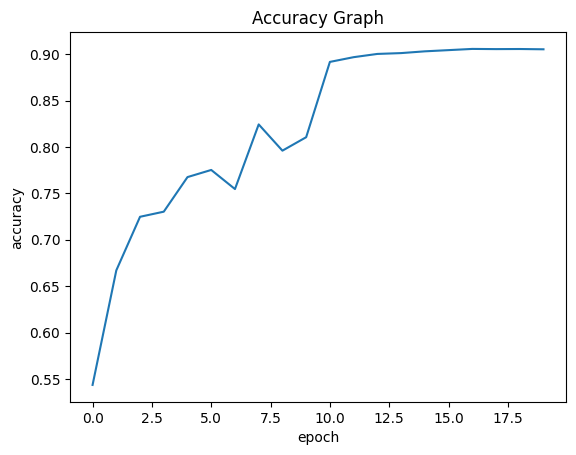

In [39]:
# plot the accuracy graph
import matplotlib.pyplot as plt
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

In [40]:
sr = True
s = 0.0001

In [41]:
# list for accuracy
accuracy_list = []
epoch_list = []


epochs = 15
start_epoch = 0

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    accuracy_list.append(prec1)
    epoch_list.append(epoch)
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.196737
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.209913
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.188236
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.160794
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.086243


/tmp/ipykernel_34/1754754961.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.3009, Accuracy: 9058/10000 (90.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.207439
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.064381
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.163565
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.139120
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.124509

Test set: Average loss: 0.3005, Accuracy: 9055/10000 (90.6%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.147441
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.113956
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.162939
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.220216
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.255686

Test set: Average loss: 0.3009, Accuracy: 9062/10000 (90.6%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.110487
Train Epoch: 3 [10000/50000 (20.0%)]	Loss: 0.097836
Train Epoch: 3 [20000/50000 (40.0%)]	Loss: 0.175427
Train Epoch: 3 [30000/50000 (60.0%)]	Loss: 0.238774
Train Epoch: 3 [40000/50000 (80.0%)]	Loss: 0.250720

Test set: Average loss: 0.2998, Accuracy: 906

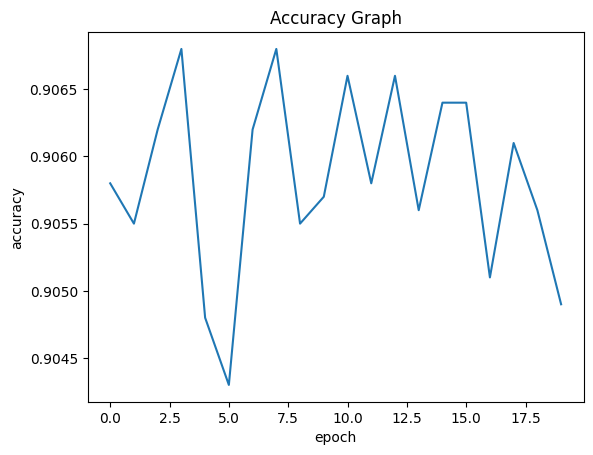

In [42]:
# plot the accuracy graph
import matplotlib.pyplot as plt
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

# **Pruned**

In [43]:
save = ''
percent = 0.5
model = ''

In [44]:
model_path = '/kaggle/working/model_best.pth.tar'
save = 'pruned.pth.tar'
percent = 0.7

In [45]:
model = vgg()
if cuda:
    model.cuda()
if model_path:
    if os.path.isfile(model_path):
        print("=> loading checkpoint '{}'".format(model_path))
        checkpoint = torch.load(model_path)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
        
print(model)

=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 4) Prec1: 0.906800
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, mo

In [46]:
total = 0
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        total += m.weight.data.shape[0]

bn = torch.zeros(total)
index = 0
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        size = m.weight.data.shape[0]
        bn[index:(index+size)] = m.weight.data.abs().clone()
        index += size

y, i = torch.sort(bn)
thre_index = int(total * percent)
thre = y[thre_index]

In [47]:
pruned = 0
cfg = []
cfg_mask = []
for k, m in enumerate(model.modules()):
    if isinstance(m, nn.BatchNorm2d):
        weight_copy = m.weight.data.clone()
        mask = weight_copy.abs().gt(thre).float().cuda()
        pruned = pruned + mask.shape[0] - torch.sum(mask)
        m.weight.data.mul_(mask)
        m.bias.data.mul_(mask)
        cfg.append(int(torch.sum(mask)))
        cfg_mask.append(mask.clone())
        print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
            format(k, mask.shape[0], int(torch.sum(mask))))
    elif isinstance(m, nn.MaxPool2d):
        cfg.append('M')

pruned_ratio = pruned/total

print('Pre-processing Successful!')

layer index: 3 	 total channel: 64 	 remaining channel: 48
layer index: 6 	 total channel: 64 	 remaining channel: 64
layer index: 10 	 total channel: 128 	 remaining channel: 126
layer index: 13 	 total channel: 128 	 remaining channel: 128
layer index: 17 	 total channel: 256 	 remaining channel: 246
layer index: 20 	 total channel: 256 	 remaining channel: 214
layer index: 23 	 total channel: 256 	 remaining channel: 162
layer index: 26 	 total channel: 256 	 remaining channel: 122
layer index: 30 	 total channel: 512 	 remaining channel: 98
layer index: 33 	 total channel: 512 	 remaining channel: 58
layer index: 36 	 total channel: 512 	 remaining channel: 23
layer index: 39 	 total channel: 512 	 remaining channel: 28
layer index: 43 	 total channel: 512 	 remaining channel: 13
layer index: 46 	 total channel: 512 	 remaining channel: 10
layer index: 49 	 total channel: 512 	 remaining channel: 42
layer index: 52 	 total channel: 512 	 remaining channel: 269
Pre-processing Succes

In [48]:
# simple test model after Pre-processing prune (simple set BN scales to zeros)
def test():
    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    model.eval()
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset)) # return accuracy

test()

/tmp/ipykernel_34/1257021953.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Accuracy: 1000/10000 (10.0%)



tensor(0.1000)

In [49]:
# Make real prune
print(cfg)
newmodel = vgg(cfg=cfg)
newmodel.cuda()

layer_id_in_cfg = 0
start_mask = torch.ones(3)
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        m1.weight.data = m0.weight.data[idx1].clone()
        m1.bias.data = m0.bias.data[idx1].clone()
        m1.running_mean = m0.running_mean[idx1].clone()
        m1.running_var = m0.running_var[idx1].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask.clone()
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d} Out shape:{:d}'.format(idx0.shape[0], idx1.shape[0]))
        w = m0.weight.data[:, idx0, :, :].clone()
        w = w[idx1, :, :, :].clone()
        m1.weight.data = w.clone()
        # m1.bias.data = m0.bias.data[idx1].clone()
    elif isinstance(m0, nn.Linear):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        m1.weight.data = m0.weight.data[:, idx0].clone()


torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, save)


[48, 64, 'M', 126, 128, 'M', 246, 214, 162, 122, 'M', 98, 58, 23, 28, 'M', 13, 10, 42, 269]
In shape: 3 Out shape:48
In shape: 48 Out shape:64
In shape: 64 Out shape:126
In shape: 126 Out shape:128
In shape: 128 Out shape:246
In shape: 246 Out shape:214
In shape: 214 Out shape:162
In shape: 162 Out shape:122
In shape: 122 Out shape:98
In shape: 98 Out shape:58
In shape: 58 Out shape:23
In shape: 23 Out shape:28
In shape: 28 Out shape:13
In shape: 13 Out shape:10
In shape: 10 Out shape:42
In shape: 42 Out shape:269


In [50]:
print(newmodel)
model = newmodel
test()

vgg(
  (feature): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(126, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

/tmp/ipykernel_34/1257021953.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Accuracy: 1000/10000 (10.0%)



tensor(0.1000)

In [51]:
refine = '/kaggle/working/pruned.pth.tar'
epochs = 15

In [52]:
seed = 1
cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

batch_size = 100
test_batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [53]:
# refine = ''

if refine:
    checkpoint = torch.load(refine)
    model = vgg(cfg=checkpoint['cfg'])
    model.cuda()
    model.load_state_dict(checkpoint['state_dict'])
else:
    model = vgg()
if cuda:
    model.cuda()

In [54]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resume = ''

if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(resume, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [55]:
s = 0.0001
# additional subgradient descent on the sparsity-induced penalty term
def updateBN():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1

In [56]:
sr = False
log_interval = 100
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        if sr:
            updateBN()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [57]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [58]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [59]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [60]:
epochs = 15
start_epoch = 0

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    accuracy_list.append(prec1)
    epoch_list.append(epoch)
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.206197
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.779033
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.537765
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.428567
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.362931


/tmp/ipykernel_34/1754754961.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.5754, Accuracy: 8219/10000 (82.2%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.560874
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.527058
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.605818
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.426614
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.477511

Test set: Average loss: 0.4857, Accuracy: 8405/10000 (84.1%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.380546
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.504097
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.250896
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.454400
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.479244

Test set: Average loss: 0.4924, Accuracy: 8405/10000 (84.1%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.279460
Train Epoch: 3 [10000/50000 (20.0%)]	Loss: 0.459893
Train Epoch: 3 [20000/50000 (40.0%)]	Loss: 0.233676
Train Epoch: 3 [30000/50000 (60.0%)]	Loss: 0.541392
Train Epoch: 3 [40000/50000 (80.0%)]	Loss: 0.240545

Test set: Average loss: 0.5827, Accuracy: 822

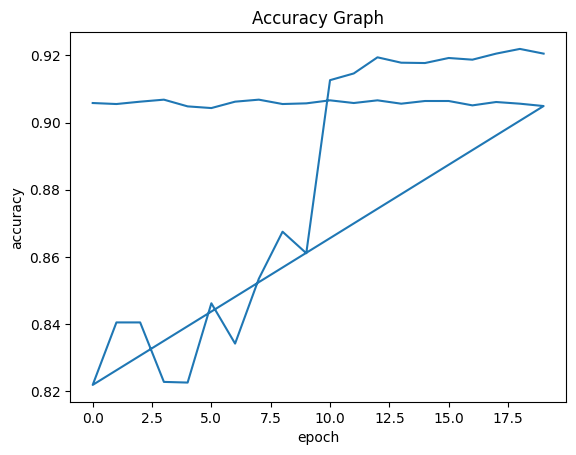

In [61]:
# plot the accuracy graph
import matplotlib.pyplot as plt
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

In [ ]:
percent_arr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
percent_accuracy_list = []
model_path = '/kaggle/working/model_best.pth.tar'
save = 'pruned.pth.tar'
for idx, percent in percent_arr:
    print('Iteration: ', idx, 'Percent: ', percent)
    model = vgg()
    if cuda:
        model.cuda()
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model_path)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    print(model)

    total = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]

    bn = torch.zeros(total)
    index = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size

    y, i = torch.sort(bn)
    thre_index = int(total * percent)
    thre = y[thre_index]

    pruned = 0
    cfg = []
    cfg_mask = []
    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm2d):
            weight_copy = m.weight.data.clone()
            mask = weight_copy.abs().gt(thre).float().cuda()
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg.append(int(torch.sum(mask)))
            cfg_mask.append(mask.clone())
            print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
                format(k, mask.shape[0], int(torch.sum(mask))))
        elif isinstance(m, nn.MaxPool2d):
            cfg.append('M')

    pruned_ratio = pruned/total

    print('Pre-processing Successful!')

    # simple test model after Pre-processing prune (simple set BN scales to zeros)
    def test():
        kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
        model.eval()
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
            correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))

    test()

    # Make real prune
    print(cfg)
    newmodel = vgg(cfg=cfg)
    newmodel.cuda()

    layer_id_in_cfg = 0
    start_mask = torch.ones(3)
    end_mask = cfg_mask[layer_id_in_cfg]
    for [m0, m1] in zip(model.modules(), newmodel.modules()):
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            m1.weight.data = m0.weight.data[idx1].clone()
            m1.bias.data = m0.bias.data[idx1].clone()
            m1.running_mean = m0.running_mean[idx1].clone()
            m1.running_var = m0.running_var[idx1].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask.clone()
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            print('In shape: {:d} Out shape:{:d}'.format(idx0.shape[0], idx1.shape[0]))
            w = m0.weight.data[:, idx0, :, :].clone()
            w = w[idx1, :, :, :].clone()
            m1.weight.data = w.clone()
            # m1.bias.data = m0.bias.data[idx1].clone()
        elif isinstance(m0, nn.Linear):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            m1.weight.data = m0.weight.data[:, idx0].clone()


    torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, save)

    print(newmodel)
    model = newmodel
    test()

    refine = '/kaggle/working/pruned.pth.tar'
    epochs = 1

    seed = 1
    cuda = torch.cuda.is_available()
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    batch_size = 100
    test_batch_size = 100
    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Pad(4),
                           transforms.RandomCrop(32),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    # refine = ''

    if refine:
        checkpoint = torch.load(refine)
        model = vgg(cfg=checkpoint['cfg'])
        model.cuda()
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model = vgg()
    if cuda:
        model.cuda()

    lr = 0.1
    momentum = 0.9
    weight_decay = 1e-4
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    resume = ''

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(resume, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    s = 0.0001
    # additional subgradient descent on the sparsity-induced penalty term
    def updateBN():
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1

    sr = False
    log_interval = 100
    def train(epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            if sr:
                updateBN()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))


    def save_checkpoint(state, is_best, filename='checkpoint_refined.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best_refined.pth.tar')

    epochs = 1
    start_epoch = 0

    best_prec1 = 0.
    for epoch in range(start_epoch, epochs):
        if epoch in [epochs*0.5, epochs*0.75]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train(epoch)
        prec1 = test()
        accuracy_list.append(prec1)
        epoch_list.append(epoch)
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    percent_accuracy_list.append(best_prec1)

    # plot the accuracy graph
    import matplotlib.pyplot as plt
    plt.plot(epoch_list, accuracy_list)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy Graph')
    plt.show()

plt.plot(percent_arr, percent_accuracy_list)
plt.xlabel('pruning percentage')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()